# Simulating TOD with beamconv
## (In particular: functionalities added in the LiteBIRD-like branch)

In this notebook, we present the changes we made to <a href="https://github.com/AdriJD/beamconv">beamconv</a> in the LiteBIRD-like branch. We show how to simulate time-ordered data (TOD) for:
- an experiment with a LiteBIRD-like scanning strategy;
- offset detectors (not at boresight);
- a noise component;
- a dipole component.

Each of these functionalities is discussed in the corresponding (numbered) section.

## 1) LiteBIRD-like scanning strategy

We have added an new module (<code>scanning.py</code>) in beamconv that allows to simulate a LiteBIRD-like scanning strategy. The <code>scanning.py</code> module is based on the <a href="https://github.com/tmatsumu/LB_SYSPL_v4.2">pyScan</a> code written by Tomotake Matsumura (IPMU).

Here we show how to use it.

#### Setting things up
First, we need to import a few modules and define some useful functions for plotting.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import healpy as hp
import time

import pysm3
import pysm3.units as u

from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('magma')
new_cmap = truncate_colormap(cmap, 0.2, 1)

#### Preparing input maps
We generate I, Q and U input maps from some pysm sky model. <a style="color:Red;">TODO: eventually use WP3's sky model.</a>

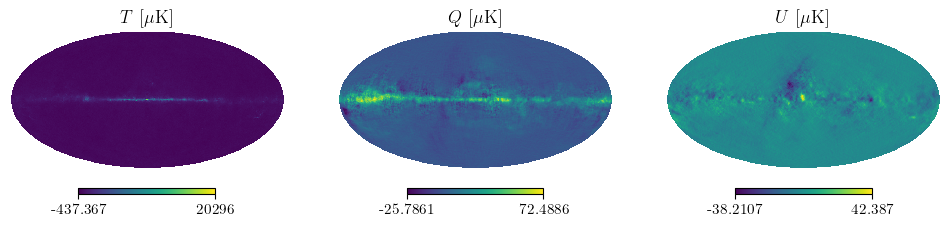

In [2]:
nside = 128
lmax = 2*nside

sky = pysm3.Sky(nside=nside, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")
nu = 140 

# generate input alm and maps
maps_pysm = sky.get_emission(nu * u.GHz)
slm = hp.map2alm(maps_pysm, lmax=lmax)
maps_temp = hp.alm2map(slm,nside=nside)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps_temp[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps_temp[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps_temp[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

Since we plan to run beamconv with <code>use_l2_scan=True</code>, we must transform the input maps in ecliptic coordinates.

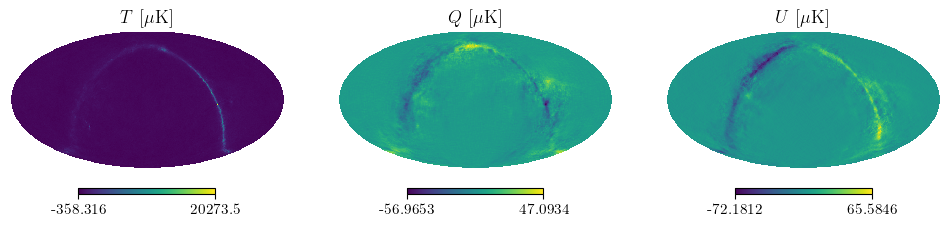

In [3]:
r = hp.Rotator(coord=['G','E'])
maps = r.rotate_map_alms(maps_temp)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

#### Setting up beamconv

First, we define a simple Gaussian beam to scan the sky. Beamconv can deal with more complex beams, that can be fed to the code as $b_{\ell m}$ spherical harmonic coefficients.

In [4]:
fwhm_arcmin = 5
single_beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)

#### Running beamconv (external pointings)

We specify the scanning strategy by directly providing the pointings.

In [5]:
ctim0 = 1510000000                    # initial time

duration = 3600*24*7                  # mission duration in s (7 days)
#duration = int(10000/19.1)

fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

ptg = np.empty((nsamp,3))             # initializing pointings array
ptg[:,0]=np.arange(nsamp)*1.5e-2      # theta
ptg[:,1]=np.arange(nsamp)*1.1e-2      # phi
ptg[:,2]=np.arange(nsamp)*np.pi*1e-2  # psi

t_samp_array = np.arange(nsamp)/fsamp # 

We run beamconv (<code>scan_instrument_mpi</code>) with those specifics and plot the hitmap.

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-11551680
from line 4556 of instrument.py: [1. 0. 0. 0.]


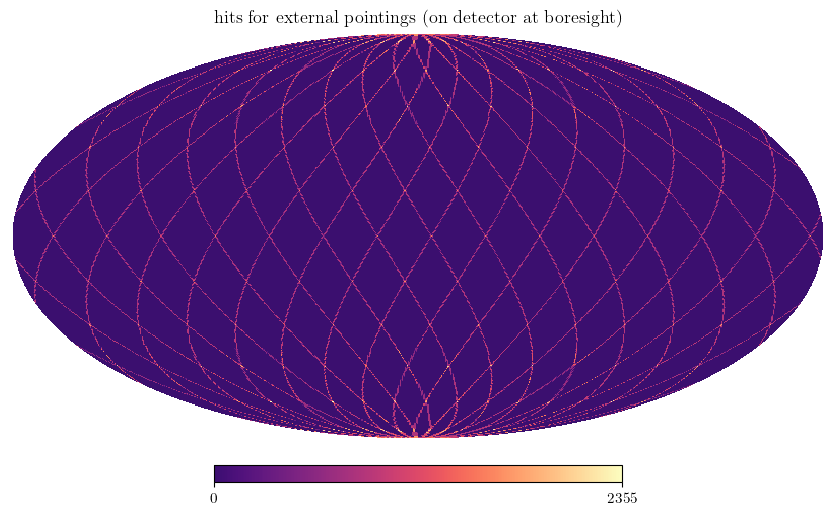

In [6]:
# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
psi = np.degrees(ptg[:,2])

# calculate the quaternion
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def ctime_test(**kwargs):
    return ctim0 + t_samp_array[kwargs.pop('start'):kwargs.pop('end')]

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.add_to_focal_plane(single_beam, combine=False)
S_ptg.allocate_maps(nside=nside)
S_ptg.scan_instrument_mpi(slm, save_tod=True, ctime_func=ctime_test, 
                          q_bore_func=q_bore_test, ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.title('hits for external pointings (on detector at boresight)')

del(S_ptg, cond, proj)

#### Running beamconv (LiteBIRD-like scanning strategy)

We re-run beamconv (<code>scan_instrument_mpi</code>) with a LiteBIRD-like scanning strategy by setting <code>use_l2_scan=True</code>.

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [1. 0. 0. 0.]


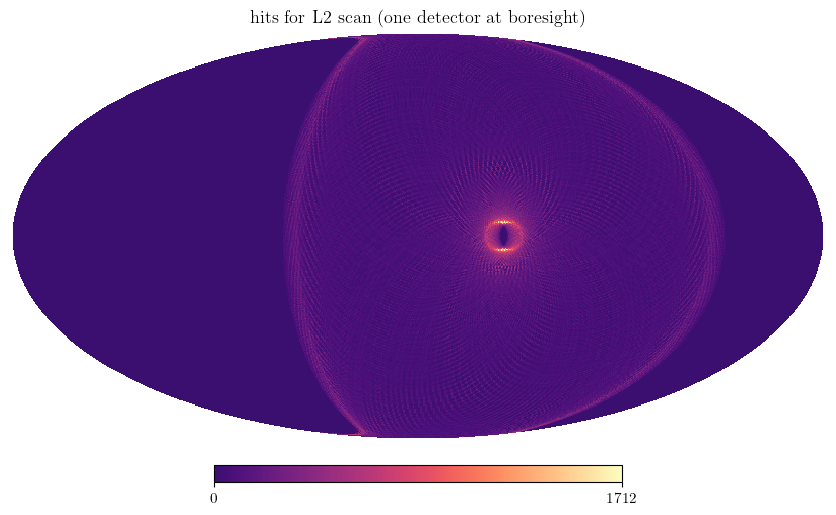

In [7]:
start = time.time()
S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0)
S_L2.add_to_focal_plane(single_beam, combine=False)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_noiseless, cond, proj = S_L2.solve_for_map(return_proj = True)

tod_noiseless = S_L2.data(S_L2.chunks[0], beam=single_beam, data_type='tod').copy()
time_noiseless = time.time() - start

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.title('hits for L2 scan (one detector at boresight)')

del(S_L2, cond, proj)

Let's check the binned maps for lower resolution.

In [8]:
nside = 16
lmax = 2*nside

sky = pysm3.Sky(nside=nside, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")
nu = 140 

# generate input alm and maps
maps_pysm = sky.get_emission(nu * u.GHz)
slm_16 = hp.map2alm(maps_pysm, lmax=lmax)
maps_16 = hp.alm2map(slm_16,nside=nside)

Tmin = np.min(maps_16[0])
Tmax = np.max(maps_16[0])

ndet = 2

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.array([[0,90],[45,135]])

# setting up the beam options
beam_opts_polangs = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm_arcmin)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, combine=True, scatter=False, **beam_opts_polangs)
S_ptg.allocate_maps(nside=nside)
S_ptg.scan_instrument_mpi(slm_16, save_tod=True, ctime_func=ctime_test, 
                          q_bore_func=q_bore_test, ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)
del(S_ptg, cond, proj)

S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0)
S_L2.input_focal_plane(azs, els, polangs, combine=True, scatter=False, **beam_opts_polangs)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(slm_16, save_tod=True, use_l2_scan=True,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_L2, cond_L2, proj = S_L2.solve_for_map(return_proj = True)
del(S_L2, proj)

Scanning with 4 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-11551680
from line 4556 of instrument.py: [1. 0. 0. 0.]
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-11551680
from line 4556 of instrument.py: [1. 0. 0. 0.]
from line 4556 of instrument.py: [1. 0. 0. 0.]
Scanning with 4 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [1. 0. 0. 0.]
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [1. 0. 0. 0.]
from line 4556 of instrument.py: [1. 0. 0. 0.]


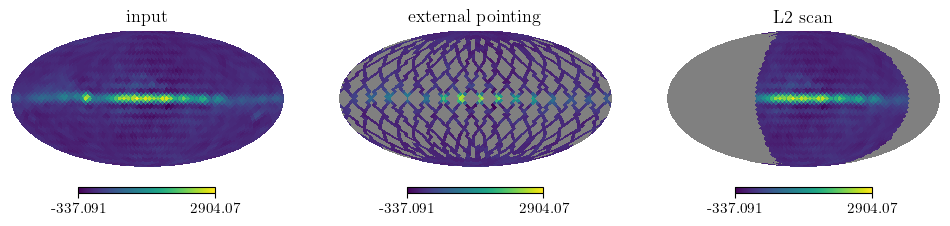

In [9]:
# plotting temperature maps
fwhm_rad = fwhm_arcmin/60/180*np.pi
smoothed_maps = hp.sphtfunc.smoothing(maps_16, fwhm=fwhm_rad)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(smoothed_maps[0], title=r'input', hold=True, min=Tmin, max=Tmax)
plt.axes(ax2)
hp.mollview(out_maps_ptg[0], title=r'external pointing', hold=True, min=Tmin, max=Tmax)
plt.axes(ax3)
hp.mollview(out_maps_L2[0], title=r'L2 scan', hold=True, min=Tmin, max=Tmax)
plt.show()

## 2) Reading detector offset quaternions

Another functionality that we added to beamconv is the possibility to feed detector offset quaternions to the
<code>input_focal_plane</code> function. This allows to account for the specific location of the detectors on the focal plane.

Here we show an example of this functionality. Note the difference between the resulting hits map and the one with a single detector at boresight.

0.0 90.0 180.0
-5.769717159787511 79.53783401465752 174.2302828402125
-1.5953863857744952 79.58734658471758 133.4046136142255
-31.74482127130421 78.5766885646945 148.2551787286958
Scanning with 8 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [0.99583508 0.00916565 0.09071095 0.        ]
[rank 000]: working on: det2, det2
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [0.92006796 0.03704628 0.08283588 0.38110463]
[rank 000]: working on: det3, det3
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
from line 4556 of instrument.py: [0.99503534 0.0523623  0.08463363 0.        ]


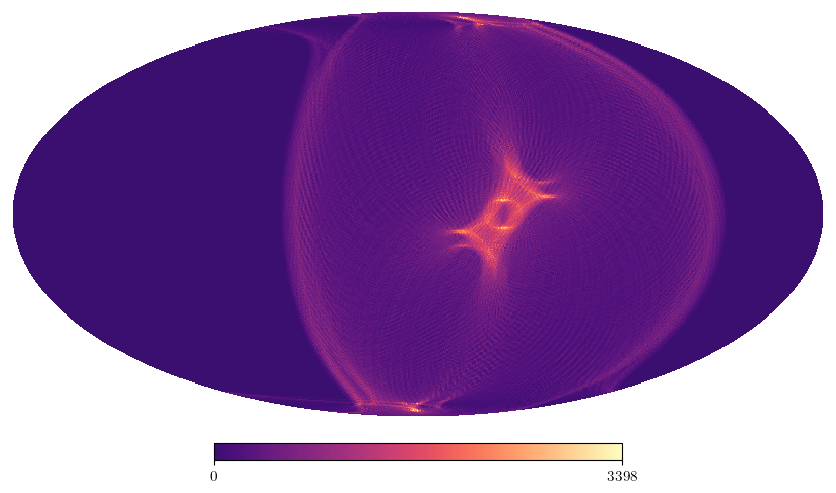

In [10]:
nside = 128
lmax = 2*nside

ndet = 4
quats = np.zeros((ndet,2,4))
quats[0,0,:] = np.array([1.,0.,0.,0.])
quats[1,0,:] = np.array([0.9958350838447524, 0.009165646421980997, 0.09071095143135842, 0.0])
quats[2,0,:] = np.array([0.9200679609994841, 0.03704627596838304, 0.08283588163313664, 0.3811046277509462])
quats[3,0,:] = np.array([0.9950353446904406, 0.05236230340491963, 0.08463363396964103, 0.0])

#quats[:,0,1] *= -1 #tried to see if it makes a difference, and it doesn't..

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))

for i in np.arange(ndet):
    ra, dec, pa = qp.QPoint().quat2radecpa(quats[i,0,:])
    print(ra, dec, pa)

deads = np.array([[0,1],[0,1],[0,1],[0,1]])

# setting up the beam options
beam_opts_quats = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm_arcmin,
                 quats=quats
                 )

S_quats = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0)
S_quats.input_focal_plane(azs, els, polangs, deads=deads, combine=True, scatter=False, **beam_opts_quats)
S_quats.allocate_maps(nside=nside)
S_quats.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True, 
                            ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_quats, cond, proj = S_quats.solve_for_map(return_proj = True)

tod_noiseless_quats = S_quats.data(S_quats.chunks[0], beam=single_beam, data_type='tod').copy()

hp.mollview(proj[0], cmap=new_cmap, title=r'')
#plt.title('hits for L2 scan (four offset detectors)')
plt.savefig('proj_quats.pdf')
del(S_quats, out_maps_quats, cond, proj)

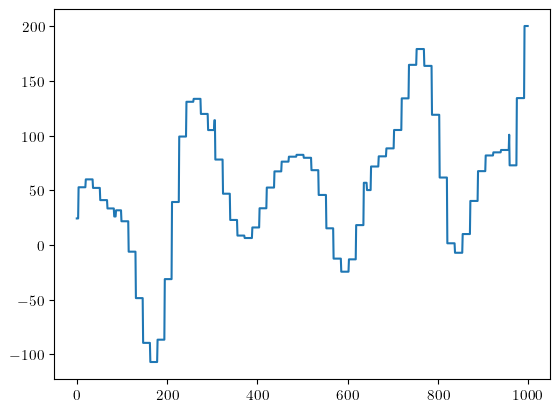

In [11]:
plt.plot(tod_noiseless_quats[:1000])

## 3) Adding a noise realization

Another new functionality implemented in the <code>LiteBIRD-like</code> branch is the possibility of adding a noise realization to the TOD, which is generated by means of the <code>OofaNoise</code> function from  <a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">ducc</a> written by Martin Reinecke (MPA).

The noise can have a white and a $1/f$ component and is described by the (frequency) power spectrum $P(f)=\sigma^2\left[\frac{f^2+f_\text{knee}^2}{f^2+f_\text{min}^2}\right]^{\frac{\alpha}{2}}$.

To generate a noisy TOD, we set <code>noise_tod=True</code> when initializing the <code>ScanStrategy</code> object and provide the necessary parameters.

In [12]:
# parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
# (for a 5 days observation, the minimum observable frequency is around 1e-6 Hz)
noise_tod = True 
sigma = 100 
f_min = 1e-5 
f_knee = 0.02 
slope = -2.0

# we initialize a ScanStrategy object with noise_tod=True and the necessary noise parameters
start = time.time()
S_noisy = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0,
                       noise_tod=noise_tod, sigma=sigma, f_min=f_min, f_knee=f_knee, f_samp=fsamp, slope=slope)
S_noisy.add_to_focal_plane(single_beam, combine=False)
S_noisy.allocate_maps(nside=nside)
S_noisy.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True,
                            ctime_kwargs=dict(), q_bore_kwargs=dict(),)
out_maps_noisy, cond, proj = S_noisy.solve_for_map(return_proj = True)

tod_noisy = S_noisy.data(S_noisy.chunks[0], beam=single_beam, data_type='tod').copy()
time_noisy = time.time() - start

del(S_noisy)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
adding noise to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]


Here we plot the first 2000 values of the noisy TOD we have just simulated, together with its noiseless counterpart.

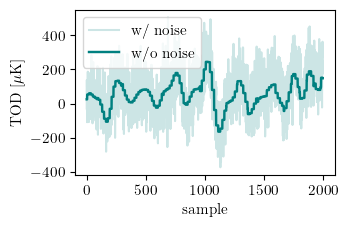

In [13]:
points=2000
color='teal'

plt.figure(figsize=(3.6, 2.4))
plt.plot(tod_noisy[:points],color=color,alpha=0.2,label='w/ noise')
plt.plot(tod_noiseless[:points],color=color,linewidth=1.75,label='w/o noise')
plt.legend()
plt.xlabel(r'sample')
plt.ylabel(r'TOD [$\mu$K]')
plt.tight_layout()
plt.savefig('noise_TOD.pdf')
plt.show()

As a countercheck, we take the difference of the noisy and noiseless TOD and check that its power spectrum tends to the theoretical one.

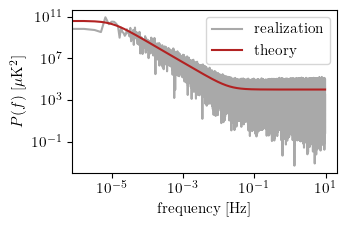

In [14]:
diff = tod_noisy - tod_noiseless

# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(diff))**2 / nsamp
time_step = 1. / fsamp
freqs = np.fft.fftfreq(diff.size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.figure(figsize=(3.6, 2.4))
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray',label='realization')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick',label='theory')
plt.legend()
plt.xlabel(r'frequency [Hz]')
plt.ylabel(r'$P(f)$ [$\mu$K$^2$]')
plt.tight_layout()
plt.savefig('noise_spectrum.pdf')
plt.show()

## 3) Adding a dipole component to the TOD
Similarly to the noise component, we have added the possibility to include a dipole component. This can generated on the fly by setting <code>dipole_tod=True</code> when itinializing the <code>ScanStrategy</code> object. What this does is to run a slightly modified version of the <code>dipole</code> module of <a href="https://github.com/litebird/litebird_sim">LiteBIRD-sim</a> framework, which returns
the dipole TOD, given the time and direction of observation. The velocity is computed
per chunk and a warning is issued whenever the chunk is too long (more than one day).

In [15]:
dipole_tod = True

# calculate TOD in 10 chunks
nchunk = 10
nsamp_chunk = int(duration*fsamp/nchunk)

start = time.time()
S_dipole = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0,
                        dipole_tod=dipole_tod, nu=nu*1e9)
chunks = S_dipole.partition_mission(nsamp_chunk)
S_dipole.add_to_focal_plane(single_beam, combine=False)
S_dipole.allocate_maps(nside=nside)
S_dipole.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True,
                             ctime_kwargs=dict(), q_bore_kwargs=dict(),)
out_maps_dipole, cond, proj = S_dipole.solve_for_map(return_proj = True)

tod_dipole = S_dipole.data(S_dipole.chunks[0], beam=single_beam, data_type='tod').copy()
time_dipole = time.time() - start

del(S_dipole)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1155168
Implementing L2 scan
adding dipole to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]:	Working on chunk 001: samples 1155168-2310336
Implementing L2 scan
adding dipole to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]:	Working on chunk 002: samples 2310336-3465504
Implementing L2 scan
adding dipole to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]:	Working on chunk 003: samples 3465504-4620672
Implementing L2 scan
adding dipole to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]:	Working on chunk 004: samples 4620672-5775840
Implementing L2 scan
adding dipole to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]:	Working on chunk 005: samples 5775840-6931008
Implementing L2 scan
adding dipole to TOD chunk
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]:	Working on chunk 006: samples 6931008-8086176
Impl

Again, we plot the first 2000 values of the TOD with and without dipole component.

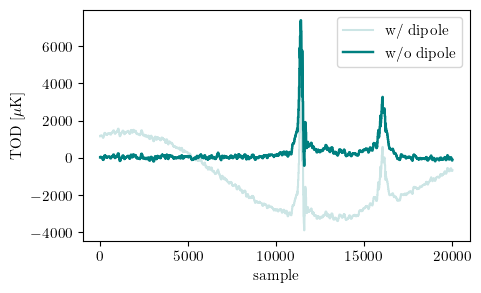

In [16]:
points=20000
color='teal'

plt.figure(figsize=(5, 3))
plt.plot(tod_dipole[:points],color=color,alpha=0.2,label='w/ dipole')
plt.plot(tod_noiseless[:points],color=color,linewidth=1.75,label='w/o dipole')
plt.legend()
plt.xlabel(r'sample')
plt.ylabel(r'TOD [$\mu$K]')
plt.savefig('dipole_TOD.pdf', bbox_inches = 'tight')
plt.show()

## Rough time requirements

As a reference, we print the time it took to simulate the TOD in the three cases we just considered: without noise and dipole, with noise (but no dipole) and with dipole (but no noise). All three TOD are simulated for a single detector with $f_\text{samp}=19.1\,\mathrm{Hz}$ taking data for 7 days. Without computing the dipole, the code takes around 18 seconds to run. When including the dipole the running time increases substantially (around 140 seconds).

In [17]:
print(time_noiseless)
print(time_noisy)
print(time_dipole)

18.477224111557007
19.87467384338379
108.03077960014343
